# imports

In [1]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

# Load Dataset

In [2]:
CSV_PATH = r"Crop_recommendation.csv"  
df = pd.read_csv(CSV_PATH)
print("Rows, Cols:", df.shape)
print("Columns:", list(df.columns))
print(df.head(3))

    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


# Drop exact duplicates

In [10]:
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Removed duplicates: {before - after}")

Removed duplicates: 0


# Check missing values

In [11]:
na_counts = df.isna().sum()
print("\nMissing values per column:\n", na_counts)
if na_counts.any():
    # Simple strategy: drop rows with NA (dataset is small & clean typically)
    df = df.dropna()
    print("Dropped rows with NA. New shape:", df.shape)


Missing values per column:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


In [13]:
df["humidity"] = df["humidity"].clip(0, 100)
df["ph"] = df["ph"].clip(0, 14)
for c in ["N", "P", "K", "rainfall", "temperature"]:
    df[c] = df[c].clip(lower=0)

#  Features (X) and Target (y)

In [14]:
FEATURES = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall"]
TARGET = "label"

X = df[FEATURES].values
y = df[TARGET].values


#  Train-Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.125, random_state=42, stratify=y_train_full
)

print(f"\nSplits → Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print("Unique classes:", len(np.unique(y)))


Splits → Train: 1540, Val: 220, Test: 440
Unique classes: 22


#  Model Training (Random Forest)

In [17]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    "n_estimators": [150, 250, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid = GridSearchCV(
    rf,
    param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("\nBest params:", grid.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


# EVALUATION (VAL + TEST)

In [18]:
def evaluate(split_name, Xs, ys, model):
    preds = model.predict(Xs)
    acc = accuracy_score(ys, preds)
    print(f"\n[{split_name}] Accuracy: {acc*100:.2f}%")
    print(classification_report(ys, preds))
    return preds

_ = evaluate("Validation", X_val, y_val, best_model)
test_preds = evaluate("Test", X_test, y_test, best_model)


[Validation] Accuracy: 99.09%
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        10
      banana       1.00      1.00      1.00        10
   blackgram       1.00      1.00      1.00        10
    chickpea       1.00      1.00      1.00        10
     coconut       1.00      1.00      1.00        10
      coffee       1.00      1.00      1.00        10
      cotton       1.00      1.00      1.00        10
      grapes       1.00      1.00      1.00        10
        jute       0.90      0.90      0.90        10
 kidneybeans       1.00      1.00      1.00        10
      lentil       1.00      1.00      1.00        10
       maize       1.00      1.00      1.00        10
       mango       1.00      1.00      1.00        10
   mothbeans       1.00      1.00      1.00        10
    mungbean       1.00      1.00      1.00        10
   muskmelon       1.00      1.00      1.00        10
      orange       1.00      1.00      1.00       

# Confusion matrix on Test

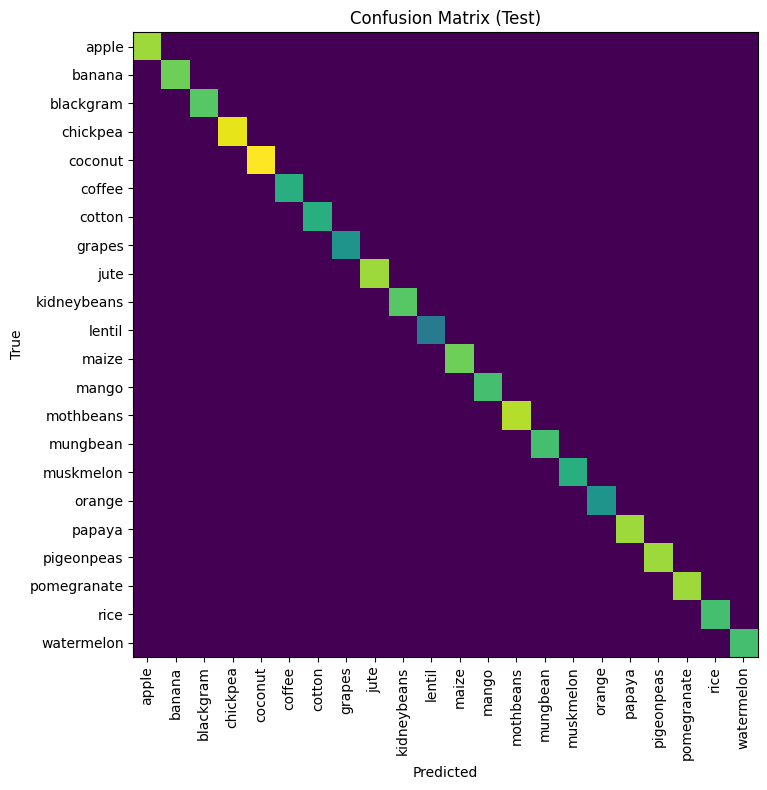

In [19]:
cm = confusion_matrix(y_test, test_preds, labels=np.unique(y))
fig = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.xticks(ticks=np.arange(len(np.unique(y))), labels=np.unique(y), rotation=90)
plt.yticks(ticks=np.arange(len(np.unique(y))), labels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


 # FEATURE IMPORTANCE (EXPLAINABILITY)

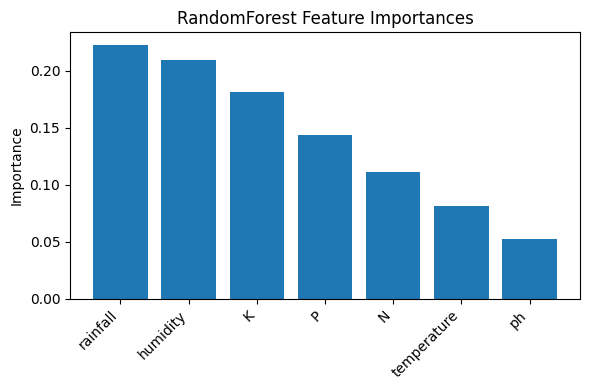


Feature importances:
rainfall     0.222
humidity     0.209
K            0.181
P            0.143
N            0.111
temperature  0.081
ph           0.052


In [21]:
importances = best_model.feature_importances_
order = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(FEATURES)), importances[order])
plt.xticks(range(len(FEATURES)), np.array(FEATURES)[order], rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.show()

print("\nFeature importances:")
for i in order:
    print(f"{FEATURES[i]:<12} {importances[i]:.3f}")

#  Predictions & Accuracy


In [22]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred) * 100)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 99.31818181818181

Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00     

C:\Users\Risha H M\AI_Crop_System\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(



# Save the Model

In [28]:
MODEL_PATH = "crop_recommendation.pkl"
META_PATH = "crop_recommendation_metadata.json"

joblib.dump(best_model, MODEL_PATH)
metadata = {
    "features": FEATURES,
    "classes": sorted(list(np.unique(y))),
    "best_params": grid.best_params_
}
with open(META_PATH, "w") as f:
    json.dump(metadata, f, indent=2)

print(f"\nSaved model → {MODEL_PATH}")
print(f" Saved metadata → {META_PATH}")


Saved model → crop_recommendation.pkl
 Saved metadata → crop_recommendation_metadata.json


#  Example Prediction

In [25]:
def predict_sample(sample_row):
    model = joblib.load(MODEL_PATH)
    with open(META_PATH, "r") as f:
        meta = json.load(f)
    feats = meta["features"]
    sample = np.array(sample_row, dtype=float).reshape(1, -1)
    pred = model.predict(sample)[0]
    proba = model.predict_proba(sample)[0]
    top_idx = np.argsort(proba)[::-1][:3]
    top = [(model.classes_[i], float(proba[i])) for i in top_idx]
    print("\nSample input (feature order):", feats)
    print("Prediction:", pred)
    print("Top-3 (class, prob):", top)

# Example (tweak as needed)
predict_sample([90, 42, 43, 20, 80, 6.5, 200])


Sample input (feature order): ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
Prediction: rice
Top-3 (class, prob): [('rice', 0.8733333333333333), ('jute', 0.11333333333333333), ('maize', 0.006666666666666667)]


In [26]:
sample_data = np.array([[60, 62, 33, 20, 80, 9, 100]])  
# Format: [N, P, K, temperature, humidity, pH, rainfall]
predicted_crop = model.predict(sample_data)
print("Recommended Crop:", predicted_crop[0])

Recommended Crop: jute


C:\Users\Risha H M\AI_Crop_System\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
